# Grading Rubric:
1. Exploratory Data Analysis: 2pts
2. Implement Feature Scaling to Normalize the data(compare the histogram/KDE for MinMaxScaler and StandardScaler): 2pts
3. Implement RFECV and show the plot between the Number of features selected vs Cross-Validation score: 2pts
4. Use elbow plot to determine the optimal number of clusters: 2pts
5. Implement KMeans Clustering and PCA: 4pts
6. Calculate variance explained by the first 2 components and by the first 4 components in PCA and visualize the clusters in the data using PCA: 2pts
7. Implement XGBoost Classifier with 5 Fold CV and report the performance metrics(precision, recall, and accuracy): 3pts
8. Provide observations and reasoning for visualizations and results included. 3pts

解释数据           https://archive.ics.uci.edu/ml/datasets/wholesale+customers
normalize data    https://towardsdatascience.com/multi-collinearity-in-regression-fe7a2c1467ea
K mean            http://www.lixiaokun.net/aimed2.html
基本完整的project   https://blog.csdn.net/weixin_39423653/article/details/81034027‘
k mean实现客户分类  https://zhuanlan.zhihu.com/p/33901249

# 0. Exploratory data analysis

## 0.1 Import and clean data
### 0.1.1 Import and view

Since our further analysis methods such as K-means and PCA is not appliciable for categorical data, we drop the categorical variables Channel and Region.
In dataset we can know there are 6 variables: Fresh, Milk, Grocery, Frozen, Detergents_Paper and Delicassen.

In [112]:
import warnings
warnings.simplefilter("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import xgboost
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

%matplotlib inline

wholesale_data = pd.read_csv('C:/Users/yuhon/Documents/2022 winter/machine learning/a2/4404/4404A2/Wholesale customers data.csv')
print("There are {} samples and {} features in dataset".format(*wholesale_data.shape))

regions = np.array(wholesale_data.Region)
channels = np.array(wholesale_data.Channel)
wholesale_data.drop(['Region', 'Channel'], axis = 1, inplace = True)

display(wholesale_data.describe())

There are 440 samples and 8 features in dataset


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


For those features, the gap from biggest to smallest from 25% to 75% is 
Fresh-> Grocery-> Milk-> Detergents_Paper-> Frozen-> Dellcassen.

## 0.2 Then we pick some random data as samples 


In [18]:
ramdom_data = [11,99,222,333]
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
display(samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,13146,1124,4523,1420,549,497
1,31276,1917,4469,9408,2381,4334
2,29729,4786,7326,6130,361,1083
3,9670,7027,10471,541,4618,65
4,5264,3683,5005,1057,2024,1130


1 fresh store -- factoy  
2 fresh frozen store --restaurant
3 fresh frozen store --restaurant
4 grocery detergents_paper store --hotel

## 0.2 Display the different channels in different regions 

# 1. Implement Feature Scaling to Normalize the data
## 1.1 KDE plot and histogram for original data

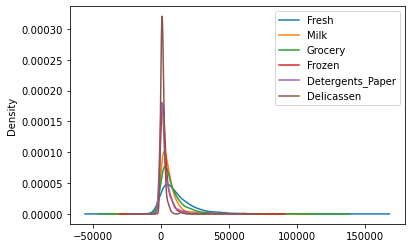

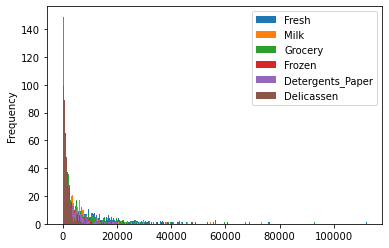

In [38]:
#KDE Plot
pd.DataFrame(wholesale_data).plot(kind='kde')
#Histogram
pd.DataFrame(wholesale_data).plot(kind='hist', bins=300)

## 1.2 KDE plot and histogram for MinMaxScaler

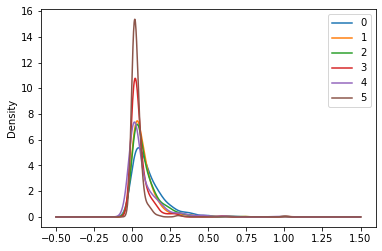

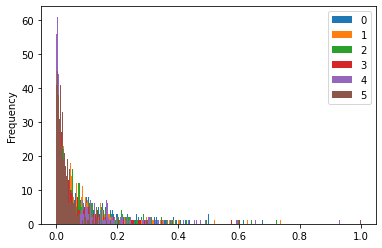

In [13]:
#scale data
scaled_minmax = MinMaxScaler().fit_transform(wholesale_data)
#KDE Plot
pd.DataFrame(scaled_minmax).plot(kind='kde')
#Histogram
pd.DataFrame(scaled_minmax).plot(kind='hist', bins=300)

## 1.3 KDE plot and histogram for StandardScaler

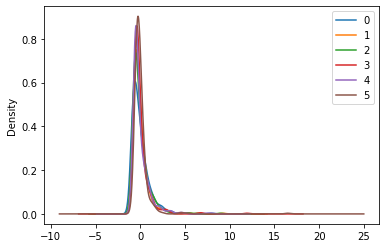

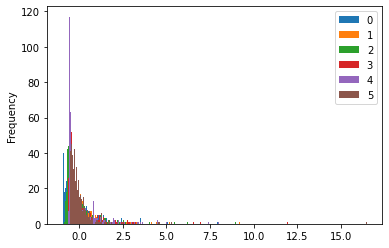

In [39]:
#scale data
scaled_std = StandardScaler().fit_transform(wholesale_data)
#KDE Plot
pd.DataFrame(scaled_std).plot(kind='kde')
#Histogram
pd.DataFrame(scaled_std).plot(kind='hist', bins=300)

# 2. Find optimal number of features using RFECV

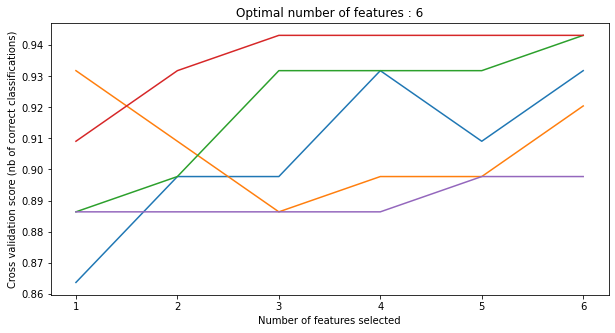

In [59]:
#prepare x and y
x_scaled = np.array(scaled_std)

#train random forest
rf = RandomForestClassifier(max_depth=7, random_state=1)
rfecv = RFECV(estimator=rf)
rfecv.fit(x_scaled, channels)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.title("Optimal number of features : %d" % rfecv.n_features_)
plt.show()

# 3. KMeans Clustering

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

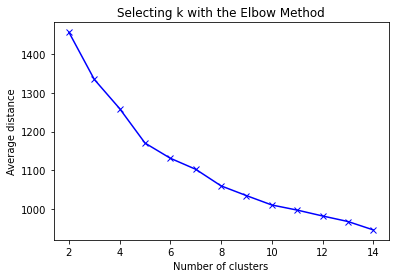

In [65]:
clusters=range(2,15)
meandist=[]

#fit model
for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(x_scaled)
    clusassign=model.predict(x_scaled)
    meandist.append(sum(np.min(cdist(x_scaled, model.cluster_centers_, 'euclidean'), axis=1),x_scaled.shape[0]))

#display elbow plot
plt.plot(clusters, meandist, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')

## 3.1 5 cluster solution

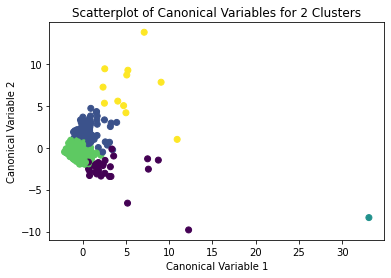

In [69]:
mode5Cluster = KMeans(n_clusters=5)
mode5Cluster.fit(x_scaled)
preds=mode5Cluster.predict(x_scaled)

#into 2D
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(x_scaled)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=mode5Cluster.labels_,)
plt.xlabel('Canonical Variable 1')
plt.ylabel('Canonical Variable 2')
plt.title('Scatterplot of Scaled Canonical Variables for 5 Clusters')
plt.show()

## 3.2 6 cluster solution

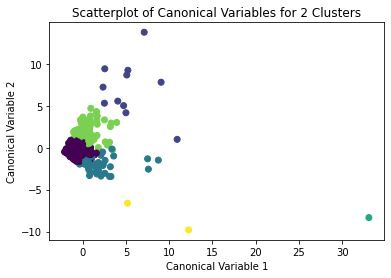

In [75]:
mode6Cluster = KMeans(n_clusters=6)
mode6Cluster.fit(x_scaled)
preds=mode6Cluster.predict(x_scaled)

#plot into 2D
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(x_scaled)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=mode6Cluster.labels_,)
plt.xlabel('Canonical Variable 1')
plt.ylabel('Canonical Variable 2')
plt.title('Scatterplot of Scaled Canonical Variables for 6 Clusters')
plt.show()

## 3.3 8 cluster solution

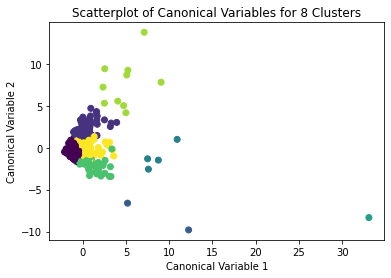

In [90]:
mode8Cluster = KMeans(n_clusters=8)
mode8Cluster.fit(x_scaled)
preds=mode8Cluster.predict(x_scaled)

#plot into 2D
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(x_scaled)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=mode8Cluster.labels_,)
plt.xlabel('Canonical Variable 1')
plt.ylabel('Canonical Variable 2')
plt.title('Scatterplot of Scaled Canonical Variables for 8 Clusters')
plt.show()

# 4. PCA

In [100]:
pca = decomposition.PCA()
scaled_pca = pca.fit_transform(x_scaled)

pca.explained_variance_ratio_

array([0.44377284, 0.30248297, 0.15032995, 0.05701507, 0.03917932,
       0.00721986])

## 4.1 Display cluster plot with two principle components

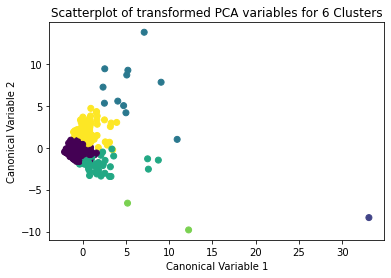

In [101]:
#fit data into a 2-componenet PCA model
pca = PCA(n_components=2)
pca.fit(x_scaled)
x_transformed = pca.transform(x_scaled)

#do clustering with 6 cluster using transformed data
mode6Cluster = KMeans(n_clusters=6)
mode6Cluster.fit(x_scaled)
preds=mode6Cluster.predict(x_scaled)

#plot into 2D
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(x_scaled)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=mode6Cluster.labels_,)
plt.xlabel('Canonical Variable 1')
plt.ylabel('Canonical Variable 2')
plt.title('Scatterplot of transformed PCA variables for 6 Clusters')
plt.show()

## 4.2 Display cluster plot with two principle components

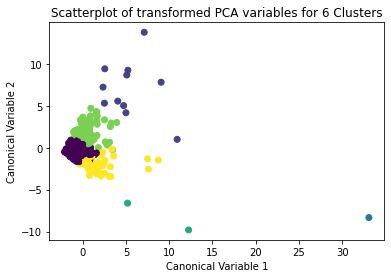

In [102]:
#fit data into a 4-componenet PCA model
pca = PCA(n_components=4)
pca.fit(x_org)
x_transformed = pca.transform(x_scaled)

#do clustering with 6 cluster using transformed data
mode6Cluster = KMeans(n_clusters=6)
mode6Cluster.fit(x_scaled)
preds=mode6Cluster.predict(x_scaled)

#plot into 2D
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(x_scaled)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=mode6Cluster.labels_,)
plt.xlabel('Canonical Variable 1')
plt.ylabel('Canonical Variable 2')
plt.title('Scatterplot of transformed PCA variables for 6 Clusters')
plt.show()

# 5. XGBoost Classifier 

In [1]:
#prepare (unscaled) original data
data_org = np.array(wholesale_data)
#channels = channels - 1

#train model
model = xgboost.XGBClassifier()
kfold = KFold(n_splits=5)
results = cross_val_score(model, data_org, channels, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

print(results)

NameError: name 'np' is not defined